In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [4]:
import os
from PIL import Image
import numpy as np

# Path to the folder containing your dataset
dataset_path = "consolidated"

# List to store image paths and labels
image_paths = []
labels = []

# Define label indices for "autistic" and "non-autistic" classes
autistic_label = 0
non_autistic_label = 1

# Iterate through subfolders
for label, subfolder in enumerate(["Autistic", "Non_Autistic"]):
    subfolder_path = os.path.join(dataset_path, subfolder)
    
    # Iterate through images in the subfolder
    for filename in os.listdir(subfolder_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append(image_path)
            labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        img = img.resize((desired_width, desired_height))  # Resize if needed
        img_array = np.array(img) / 255.0  # Normalize pixel values
        img_array = img_array[..., np.newaxis]  # Add extra dimension for convolution channels
        images.append(img_array)
    return np.array(images)

# Load and preprocess images
desired_width, desired_height = 28, 28  # Adjust the dimensions as needed
images = load_and_preprocess_images(image_paths)

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


In [5]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [7]:
# Quantum pre-processing of train images
q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_images):
    print("{}/{}        ".format(idx + 1, len(train_images)), end="\r")
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

# Quantum pre-processing of test images
q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1, len(test_images)), end="\r")
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

# Save pre-processed images
SAVE_PATH = "your_save_path/"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

Quantum pre-processing of train images:


/var/folders/s5/3vrfy9z53w54xh40slw5vx980000gn/T/ipykernel_3316/1047481265.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j // 2, k // 2, c] = q_results[c]


2352/2352        
Quantum pre-processing of test images:


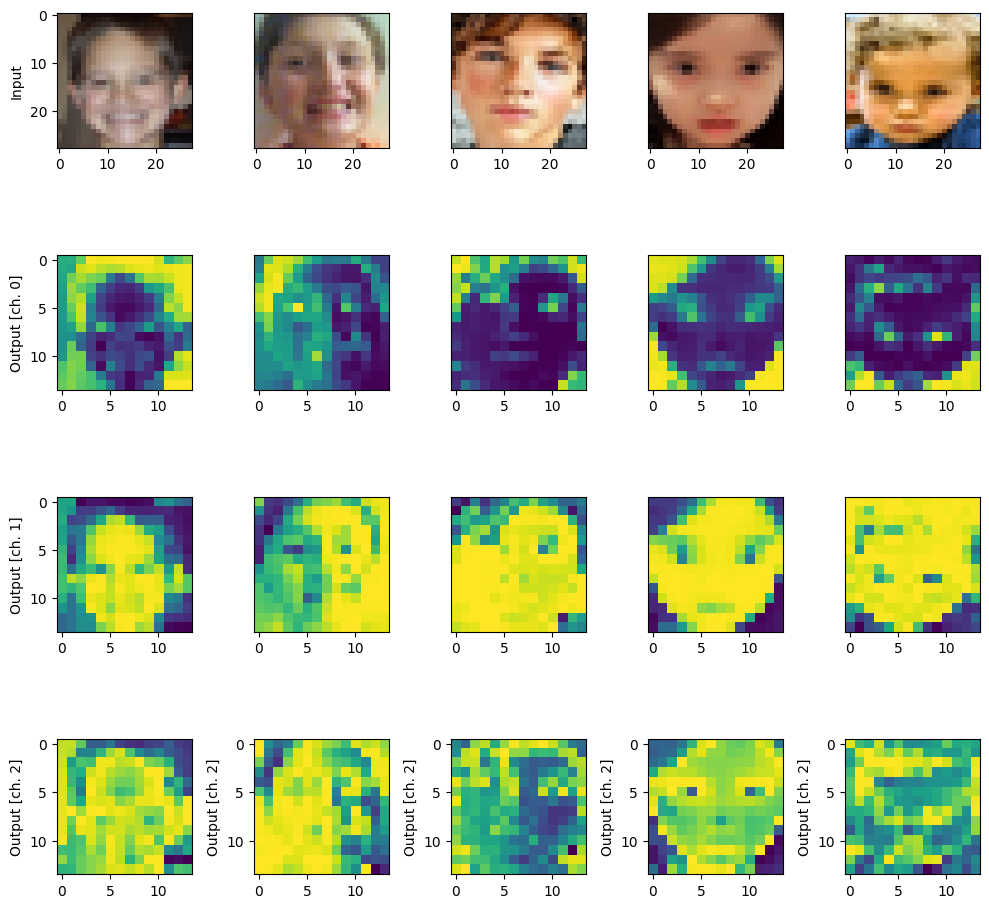

In [10]:
import matplotlib.pyplot as plt

n_samples = 5
n_channels = 3  # Assuming RGB color images
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    axes[0, k].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k].reshape(28, 28, 3))
    
    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, k].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c])

plt.tight_layout()
plt.show()


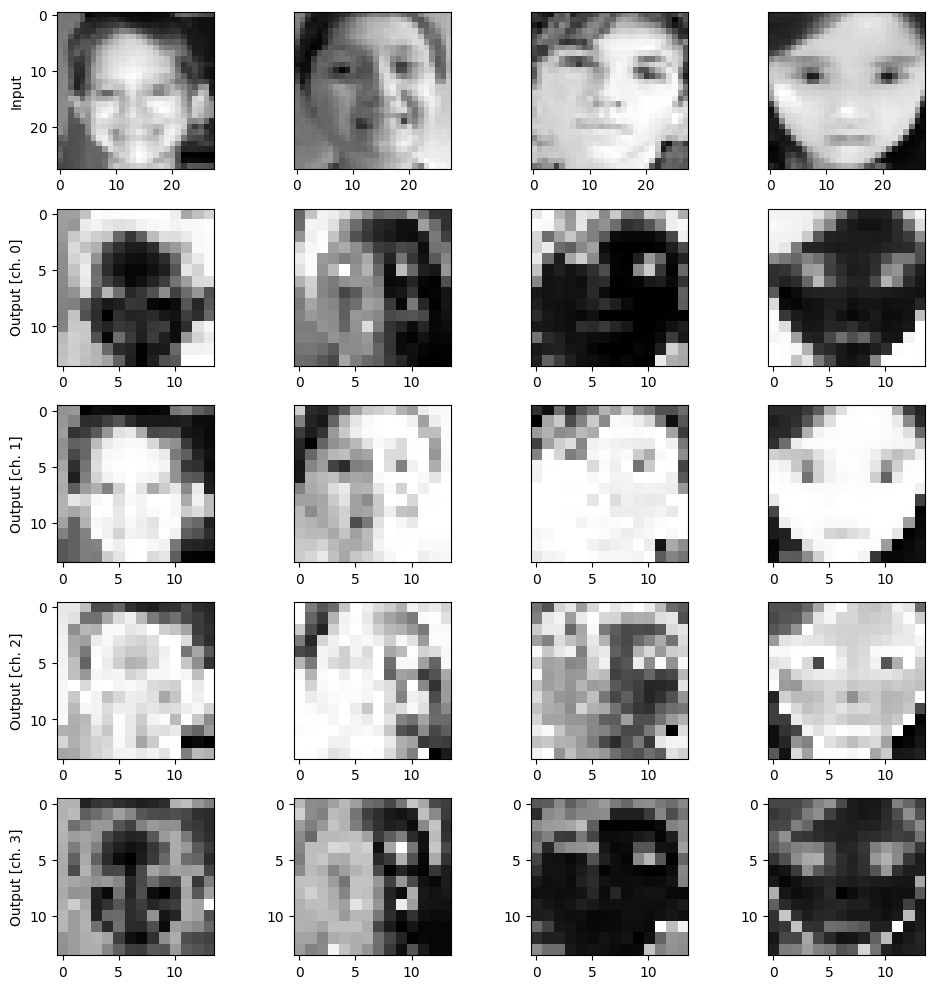

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
588/588 - 0s - loss: 0.6947 - accuracy: 0.6165 - val_loss: 0.6585 - val_accuracy: 0.6565 - 363ms/epoch - 618us/step
Epoch 2/30
588/588 - 0s - loss: 0.6064 - accuracy: 0.6866 - val_loss: 1.0332 - val_accuracy: 0.5272 - 203ms/epoch - 346us/step
Epoch 3/30
588/588 - 0s - loss: 0.5954 - accuracy: 0.6956 - val_loss: 0.7317 - val_accuracy: 0.6139 - 201ms/epoch - 342us/step
Epoch 4/30
588/588 - 0s - loss: 0.5746 - accuracy: 0.7024 - val_loss: 0.6520 - val_accuracy: 0.6582 - 201ms/epoch - 342us/step
Epoch 5/30
588/588 - 0s - loss: 0.5627 - accuracy: 0.7058 - val_loss: 0.7925 - val_accuracy: 0.5935 - 200ms/epoch - 340us/step
Epoch 6/30
588/588 - 0s - loss: 0.5461 - accuracy: 0.7202 - val_loss: 0.6341 - val_accuracy: 0.6735 - 199ms/epoch - 339us/step
Epoch 7/30
588/588 - 0s - loss: 0.5471 - accuracy: 0.7211 - val_loss: 0.6185 - val_accuracy: 0.6820 - 200ms/epoch - 341us/step
Epoch 8/30
588/588 - 0s - loss: 0.5434 - accuracy: 0.7228 - val_loss: 0.6387 - val_accuracy: 0.6463 - 199ms/epo

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
588/588 - 0s - loss: 0.8000 - accuracy: 0.5604 - val_loss: 0.7875 - val_accuracy: 0.6037 - 334ms/epoch - 568us/step
Epoch 2/30
588/588 - 0s - loss: 0.7152 - accuracy: 0.6241 - val_loss: 1.2677 - val_accuracy: 0.5255 - 212ms/epoch - 361us/step
Epoch 3/30
588/588 - 0s - loss: 0.7119 - accuracy: 0.6522 - val_loss: 0.7159 - val_accuracy: 0.6241 - 212ms/epoch - 360us/step
Epoch 4/30
588/588 - 0s - loss: 0.6413 - accuracy: 0.6590 - val_loss: 0.6545 - val_accuracy: 0.6548 - 212ms/epoch - 360us/step
Epoch 5/30
588/588 - 0s - loss: 0.6158 - accuracy: 0.6896 - val_loss: 0.6381 - val_accuracy: 0.6565 - 211ms/epoch - 359us/step
Epoch 6/30
588/588 - 0s - loss: 0.6264 - accuracy: 0.6858 - val_loss: 0.7671 - val_accuracy: 0.6259 - 212ms/epoch - 361us/step
Epoch 7/30
588/588 - 0s - loss: 0.6483 - accuracy: 0.6756 - val_loss: 0.6228 - val_accuracy: 0.6735 - 211ms/epoch - 360us/step
Epoch 8/30
588/588 - 0s - loss: 0.6161 - accuracy: 0.6943 - val_loss: 0.6394 - val_accuracy: 0.6582 - 211ms/epo

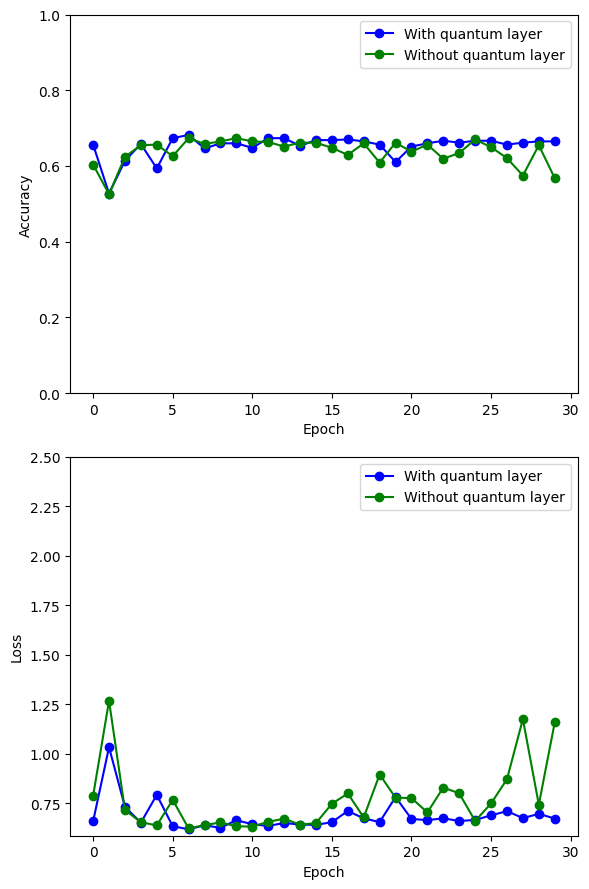

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()